In [63]:
import torch
import numpy as np
import random
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


class MovingMNIST(torch.utils.data.Dataset):
    def __init__(self, num_sequences=1000, sequence_length=20, image_size=32, digit_size=28, speed=2):
        self.mnist = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
        self.num_sequences = num_sequences
        self.sequence_length = sequence_length
        self.image_size = image_size
        self.digit_size = digit_size
        self.speed = speed  # pixels/frame

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        canvas_size = self.image_size #32x32 looks similiar as in paper increase if required
        frames = np.zeros((self.sequence_length, canvas_size, canvas_size), dtype=np.float32)

        # Select a random MNIST digit
        digit_img, _ = self.mnist[random.randint(0, len(self.mnist) - 1)]
        digit_img = digit_img.squeeze(0).numpy()

        # Random direction: -1 (left) or +1 (right)
        direction = random.choice([-1, 1])
        dx = direction * self.speed  # no of pixel left/right

        # Random start
        x = random.randint(0, canvas_size - 1)
        y = random.randint(0, canvas_size - self.digit_size)
        #y = (canvas_size - self.digit_size) // 2  # center vertically if needed

        for t in range(self.sequence_length):
            x_int = int(np.floor(x)) % canvas_size  # wrap x using modulo

            # Handle wrap-around drawing
            if x_int + self.digit_size <= canvas_size:
                # Fully inside canvas
                frames[t, y:y+self.digit_size, x_int:x_int + self.digit_size] += digit_img
            else:
                # Split across right and left border
                right_part = canvas_size - x_int
                left_part = self.digit_size - right_part

                # Right slice
                frames[t, y:y+self.digit_size, x_int:] += digit_img[:, :right_part]
                # Left slice
                frames[t, y:y+self.digit_size, :left_part] += digit_img[:, right_part:]

            x += dx  # move with wrapping

        frames = np.clip(frames, 0, 1)
        frames = torch.tensor(frames).unsqueeze(1)  # shape: (T, 1, H, W)
        return frames


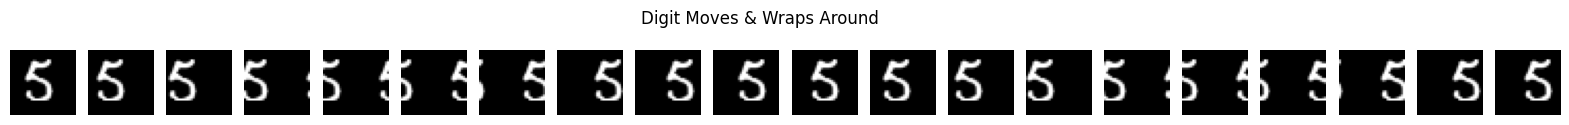

In [64]:
dataset = MovingMNIST(sequence_length=20, speed=3)
sequence = dataset[0]

def show_sequence(frames, title="Wrapped Digit Movement"):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, len(frames), figsize=(len(frames), 1.5))
    for i, ax in enumerate(axes):
        ax.imshow(frames[i, 0], cmap="gray")
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

show_sequence(sequence, title="Digit Moves & Wraps Around")
